In [1]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.compat.v1.Session(config=config))

2023-07-05 13:48:04.859144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 13:48:05.389863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-05 13:48:06.120413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 13:48:06.136421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Activation 
from tensorflow.keras.layers import Dropout 
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
from tensorflow.keras import metrics

/home/choij/miniconda3/envs/kias/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
import h5py
import numpy as np

filename = "./Particle_Images/data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"
data1 = h5py.File(filename, "r")
Y1 = data1["y"][:200000]
X1 = data1["X"][:200000]
filename = "./Particle_Images/data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
data0 = h5py.File(filename, "r")
Y0 = data0["y"][:200000]
X0 = data0["X"][:200000]
X_final = np.concatenate((X0[:], X1[:]), axis=0)
Y_final = np.concatenate((Y0[:], Y1[:]), axis=0)

(200000, 32, 32, 2)


In [7]:
X_final.shape

(400000, 32, 32, 2)

In [8]:
input_shape = (32, 32, 2) #Using the Hit-Energy channel only

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X_final[:, :, :, 0:1],
    Y_final,
    test_size=0.2,
    random_state=42
)
    
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (320000, 32, 32, 1) - y_train shape: (320000,)
x_test shape: (80000, 32, 32, 1) - y_test shape: (80000,)


In [7]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 20
image_size = 32 # We'll resize input images to this size
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [256,128]  # Size of the dense layers of the final classifier

In [8]:

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        #layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(
         #   height_factor = 0.2, width_factor = 0.2
        #),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2023-07-05 12:40:47.466666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 12:40:47.466986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-05 12:40:47.467206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 16


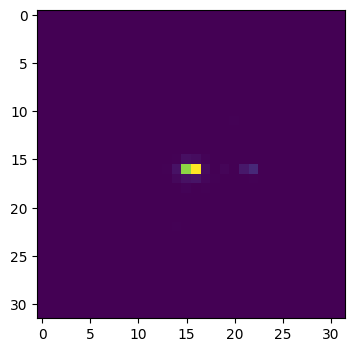

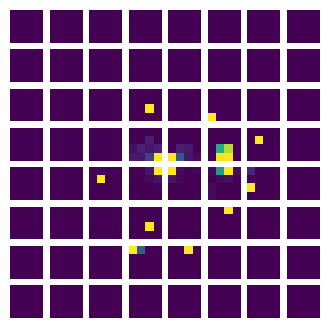

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[0,:,:,0]
plt.imshow(image.astype("float32"))
#plt.axis("off")

patches = Patches(patch_size)(x_train[0:1,:,:,0:1])
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img.numpy().astype("float32"))
    plt.axis("off")

In [12]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [13]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
        

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [14]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,#keras.optimizers.Adam(lr=0.001),
        loss= keras.losses.BinaryCrossentropy(from_logits=True),#'binary_crossentropy',
        #loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            'accuracy',
            'mae'
        ]
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/20
2382/2382 [==============================] - 85s 34ms/step - loss: 0.6966 - accuracy: 0.4995 - mae: 0.5253 - val_loss: 0.6933 - val_accuracy: 0.5001 - val_mae: 0.4997
Epoch 2/20
2382/2382 [==============================] - 79s 33ms/step - loss: 0.6477 - accuracy: 0.5810 - mae: 0.6720 - val_loss: 0.5898 - val_accuracy: 0.6652 - val_mae: 0.7977
Epoch 3/20
2382/2382 [==============================] - 79s 33ms/step - loss: 0.5962 - accuracy: 0.6652 - mae: 0.8207 - val_loss: 0.6002 - val_accuracy: 0.6771 - val_mae: 0.9954
Epoch 4/20
2382/2382 [==============================] - 79s 33ms/step - loss: 0.5859 - accuracy: 0.6790 - mae: 0.8534 - val_loss: 0.6234 - val_accuracy: 0.6956 - val_mae: 0.7257
Epoch 5/20
2382/2382 [==============================] - 79s 33ms/step - loss: 0.5815 - accuracy: 0.6844 - mae: 0.8697 - val_loss: 0.5657 - val_accuracy: 0.7041 - val_mae: 0.9123
Epoch 6/20
2382/2382 [==============================] - 92s 39ms/step - loss: 0.5798 - accuracy: 0.6852 - mae:

KeyboardInterrupt: 